In [173]:
import tensorflow as tf  
import numpy as np          
import argparse
import pandas as pd
from termcolor import colored
import anndata as ad

# 1 Read in data

In [174]:
# Blood ROSMAP
ROSMAPFrame = pd.read_csv("../../../Data/ROSMAP_blood_gene_expression_monocyte_ACTL_04172023.csv",header=0, index_col=0)
ROSMAPSampleID = list(ROSMAPFrame.columns.values)
ROSMAPGeneID = list(ROSMAPFrame.index.values)

# Blood ANMerge
ANMergeFrame = pd.read_csv("../../../Data/ADNI_blood_gene_expression_gene_aligned_04172023.csv",header=0, index_col=0)
ANMergeGeneID = list(ANMergeFrame.index.values)
ANMergeSampleID = list(ANMergeFrame.columns.values)

In [175]:
# log transform ROSMAP
ROSMAPFrame = np.log(ROSMAPFrame+1)

# gene overlap between ROSMAP and ANMerge
OverlapGene = list(set(ROSMAPGeneID) & set(ANMergeGeneID))
print("Number of overlapped gene is", colored(len(OverlapGene), 'red'))

Number of overlapped gene is 7704


## 1.1 Aligned dataframe to make their gene aligned

In [176]:
ROSMAPFrame = ROSMAPFrame.loc[OverlapGene,:]
ANMergeFrame = ANMergeFrame.loc[OverlapGene,:]

In [177]:
ROSMAPFrame.columns

Index(['Sample_003', 'Sample_004', 'Sample_014', 'Sample_021', 'Sample_031',
       'Sample_037', 'Sample_040', 'Sample_050', 'Sample_057', 'Sample_058',
       ...
       'Sample_563', 'Sample_572', 'Sample_573', 'Sample_578', 'Sample_580',
       'Sample_581', 'Sample_582', 'Sample_588', 'Sample_590', 'Sample_608'],
      dtype='object', length=157)

In [178]:
anndata_ROSMAP = ad.AnnData(ROSMAPFrame.values)
anndata_ROSMAP = anndata_ROSMAP.T
anndata_ROSMAP.obs_names = list(ROSMAPFrame.columns)
anndata_ROSMAP.var_names = list(ROSMAPFrame.index)

In [179]:
anndata_Target = ad.AnnData(ANMergeFrame.values)
anndata_Target = anndata_Target.T
anndata_Target.obs_names = list(ANMergeFrame.columns)
anndata_Target.var_names = list(ANMergeFrame.index)

## 1.2 Read in labels

In [180]:
# read in label
ROSMAP_Info = pd.read_csv("../../../Data/ROSMAP_blood_clinical_monocyte_ACTL_04172023.csv",header=0, index_col=0)

# read in label
ANMerge_Info = pd.read_csv("../../../Data/ADNI_NewModel_NewLabel_Clinical_Info.csv",header=0, index_col=0)
    

In [181]:
ROSMAP_Info.head(2)

,individualID,projid,msex,race,apoe_genotype,age_at_visit_max,age_death,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,Group1,Group2,specimenID
1,R1528689,402800,0,1,34.0,79.701574264202605,80.65708418891171,13.0,5.500000,5,1,4,4,Typical AD,Typical.AD,Sample_003
2,R3978789,482428,0,1,23.0,82.321697467488022,83.690622861054067,30.0,3.933333,4,4,1,1,Asym AD,Asym.AD,Sample_004


In [182]:
import collections

ROSMAP_SID = list(ROSMAP_Info.loc[:,'specimenID'])
ROSMAP_Class = list(ROSMAP_Info.loc[:,'Group1'])
ROSMAP_braaksc = list(ROSMAP_Info.loc[:,'braaksc'])

Mapping_ROSMAP_SID_Class = dict(zip(ROSMAP_SID, ROSMAP_Class))
Mapping_ROSMAP_SID_braak = dict(zip(ROSMAP_SID, ROSMAP_braaksc))

SID = anndata_ROSMAP.obs_names
ClassList = list()
BraakList = list()
for st in SID:
    ClassList.append(Mapping_ROSMAP_SID_Class[st])
    BraakList.append(Mapping_ROSMAP_SID_braak[st])
    
anndata_ROSMAP.obs['Label'] = ClassList
anndata_ROSMAP.obs['braaksc'] = BraakList


In [183]:
anndata_ROSMAP.obs.head(2)

,Label,braaksc
Sample_003,Typical AD,5
Sample_004,Asym AD,4


In [184]:
ANMerge_Info.head(2)

,Label,Gender,Age,DX,Progressed,MMSE_Month,MMSE_Close,MMSE_BL,CDRSB_BL,PTAU_Close,TAU_Close,AV45_Close,CDRSB_Month,first_changing_time,n_counts_all,braaksc_trans,NewLabel
116_S_1249,Asym AD,Female,75,CN,Yes,30.0,30.0,30.0,0.0,inf,inf,inf,0.0,35.836066,46323.804849,4.0,Others
037_S_4410,Asym AD,Female,69,CN,No,29.0,29.0,29.0,0.0,29.14,313.5,0.9862,0.0,61.475410,46533.937284,2.0,Control


In [185]:
ANMerge_SID = list(ANMerge_Info.index)
ANMerge_Class = list(ANMerge_Info.loc[:,'DX'])
ANMerge_CDRSB = list(ANMerge_Info.loc[:,'CDRSB_Month'])

Mapping_Target_SID_Class = dict(zip(ANMerge_SID, ANMerge_Class))
Mapping_Target_SID_CDRSB = dict(zip(ANMerge_SID, ANMerge_CDRSB))

SID = anndata_Target.obs_names
DXlist = list()
CDRlist = list()
for st in SID:
    DXlist.append(Mapping_Target_SID_Class[st])
    CDRlist.append(Mapping_Target_SID_CDRSB[st])
    

anndata_Target.obs['DX'] = DXlist
anndata_Target.obs['CDRSB_Month'] = CDRlist

In [186]:
anndata_Target.obs

,DX,CDRSB_Month
116_S_1249,CN,0.0
037_S_4410,CN,0.0
006_S_4153,Dementia,3.0
116_S_1232,CN,0.0
099_S_4205,MCI,0.5
...,...,...
009_S_2381,MCI,2.5
053_S_4557,MCI,2.5
073_S_4300,MCI,1.5
041_S_4014,CN,0.0


# 2 Run MMD-MA

In [187]:
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import linear_kernel
import scipy as scip

## 2.1 compute  Gaussian Kernel 

In [188]:
# s is the parameter for the Gaussian kernel
s1 = 10
s2 = 10

# K1 is the Gaussian Kernel for ROSMAP
# XR should be an NxD matrix, where N is number of obs and D its features
XR = anndata_ROSMAP.X #ROSMAPFrame.values.T
pairwise_sq_dists = squareform(pdist(XR, 'sqeuclidean'))
K1 = np.exp(-pairwise_sq_dists / s1**2)

# K2 is the Gaussian Kernel for ANMerge
# XR should be an NxD matrix, where N is number of obs and D its features
XA = anndata_Target.X #ANMergeFrame.values.T
pairwise_sq_dists = squareform(pdist(XA, 'sqeuclidean'))
K2 = np.exp(-pairwise_sq_dists / s2**2)

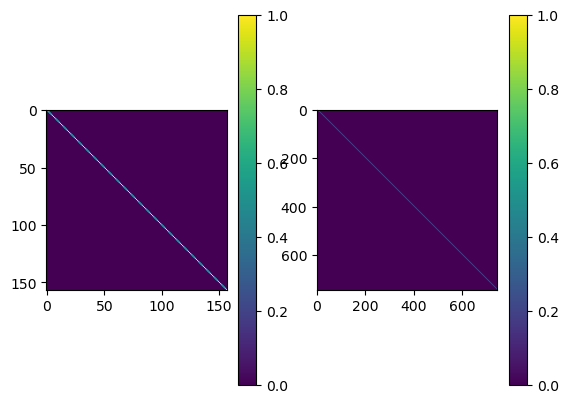

In [189]:
# draw the plot to better choose s1 and s2
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
im = ax[0].imshow(K1)
fig.colorbar(im,ax=ax[0])
im2 = ax[1].imshow(K2)
fig.colorbar(im2,ax=ax[1])

## 1.2 MMD-MA

In [190]:
def compute_pairwise_distances(x, y):
    """Computes the squared pairwise Euclidean distances between x and y.
  Args:
    x: a tensor of shape [num_x_samples, num_features]
    y: a tensor of shape [num_y_samples, num_features]
  Returns:
    a distance matrix of dimensions [num_x_samples, num_y_samples].
  Raises:
    ValueError: if the inputs do no matched the specified dimensions.
  """

    if not len(x.get_shape()) == len(y.get_shape()) == 2:
        raise ValueError('Both inputs should be matrices.')

    if x.get_shape().as_list()[1] != y.get_shape().as_list()[1]:
        raise ValueError('The number of features should be the same.')

    norm = lambda x: tf.reduce_sum(tf.square(x), 1)

  # By making the `inner' dimensions of the two matrices equal to 1 using
  # broadcasting then we are essentially substracting every pair of rows
  # of x and y.
  # x will be num_samples x num_features x 1,
  # and y will be 1 x num_features x num_samples (after broadcasting).
  # After the substraction we will get a
  # num_x_samples x num_features x num_y_samples matrix.
  # The resulting dist will be of shape num_y_samples x num_x_samples.
  # and thus we need to transpose it again.
    return tf.transpose(norm(tf.expand_dims(x, 2) - tf.transpose(y)))

def gaussian_kernel_matrix(x, y, sigmas):
    """Computes a Guassian Radial Basis Kernel between the samples of x and y.
  We create a sum of multiple gaussian kernels each having a width sigma_i.
  Args:
    x: a tensor of shape [num_samples, num_features]
    y: a tensor of shape [num_samples, num_features]
    sigmas: a tensor of floats which denote the widths of each of the
      gaussians in the kernel.
  Returns:
    A tensor of shape [num_samples{x}, num_samples{y}] with the RBF kernel.
  """
    beta = 1. / (2. * (tf.expand_dims(sigmas, 1)))
    dist = compute_pairwise_distances(x, y)
    s = tf.matmul(beta, tf.reshape(dist, (1, -1)))

    return tf.reshape(tf.reduce_sum(tf.exp(-s), 0), tf.shape(dist))

def maximum_mean_discrepancy(x, y, kernel=gaussian_kernel_matrix, bandwidth=1.0):
    """Computes the Maximum Mean Discrepancy (MMD) of two samples: x and y.
  Maximum Mean Discrepancy (MMD) is a distance-measure between the samples of
  the distributions of x and y. Here we use the kernel two sample estimate
  using the empirical mean of the two distributions.
  MMD^2(P, Q) = || \E{\phi(x)} - \E{\phi(y)} ||^2
              = \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) },
  where K = <\phi(x), \phi(y)>,
    is the desired kernel function, in this case a radial basis kernel.
  Args:
      x: a tensor of shape [num_samples, num_features]
      y: a tensor of shape [num_samples, num_features]
      kernel: a function which computes the kernel in MMD. Defaults to the
              GaussianKernelMatrix.
  Returns:
      a scalar denoting the squared maximum mean discrepancy loss.
  """
    with tf.name_scope('MaximumMeanDiscrepancy'):
        # \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) }
        cost = tf.reduce_mean(kernel(x, x, tf.constant([bandwidth])))
        cost += tf.reduce_mean(kernel(y, y, tf.constant([bandwidth])))
        cost -= 2 * tf.reduce_mean(kernel(x, y, tf.constant([bandwidth])))

        # We do not allow the loss to become negative.
        cost = tf.where(cost > 0, cost, 0, name='value')
    return cost

In [191]:
k1_matrix = K1
k2_matrix = K2
n1 = k1_matrix.shape[0]
n2 = k2_matrix.shape[0]
K1 = tf.constant(k1_matrix, dtype=tf.float32)
K2 = tf.constant(k2_matrix, dtype=tf.float32)

p = 10 # embeded dim 
k = 100 # random seed
training_rate = 0.00005
bandwidth = 1.0
tradeoff2 = 0.01
tradeoff3 = 0.001
I_p=tf.eye(p)

In [192]:
alpha = tf.Variable(tf.random.uniform([n1, p], minval=0.0, maxval=0.1, seed=k))
beta = tf.Variable(tf.random.uniform([n2, p], minval=0.0, maxval=0.1, seed=k))

optimizer = tf.keras.optimizers.Adam(learning_rate=training_rate)
objbest = 1e20
for i in range(5001):
    with tf.GradientTape() as tape:
        mmd_part = maximum_mean_discrepancy(tf.matmul(K1, alpha), tf.matmul(K2, beta), bandwidth=bandwidth)
        penalty_part = tradeoff2 * (tf.norm(tf.subtract(tf.matmul(tf.transpose(alpha), tf.matmul(K1, alpha)), I_p), ord=2) + tf.norm(tf.subtract(tf.matmul(tf.transpose(beta), tf.matmul(K2, beta)), I_p), ord=2))
        distortion_part = tradeoff3 * (tf.norm(tf.subtract(tf.matmul(tf.matmul(K1, alpha), tf.matmul(tf.transpose(alpha), tf.transpose(K1))), K1), ord=2) + tf.norm(tf.subtract(tf.matmul(tf.matmul(K2, beta), tf.matmul(tf.transpose(beta), tf.transpose(K2))), K2), ord=2))
        myFunction = mmd_part + penalty_part + distortion_part

    gradients = tape.gradient(myFunction, [alpha, beta])
    optimizer.apply_gradients(zip(gradients, [alpha, beta]))

    #if i % 100 == 0:
    if objbest > myFunction.numpy():
        objbest = myFunction.numpy()
        alpha_best = alpha.numpy()
        beta_best = beta.numpy()
        besti = i
        rec = '\t'.join([str(k), str(i), str(myFunction.numpy()), str(mmd_part.numpy()), str(penalty_part.numpy()), str(distortion_part.numpy())])
        print(rec)
        #record.write(rec + '\n')

np.savetxt("alpha_hat_" + str(k) + "_" + str(besti) + ".txt", alpha_best)
np.savetxt("beta_hat_" + str(k) + "_" + str(besti) + ".txt", beta_best)

100	0	0.27502513	4.184246e-05	0.22913241	0.04585087
100	1	0.2745619	4.184246e-05	0.22869296	0.045827113
100	2	0.2740989	4.184246e-05	0.22825366	0.04580339
100	3	0.27363625	4.184246e-05	0.2278147	0.045779716
100	4	0.2731741	4.184246e-05	0.22737616	0.045756094
100	5	0.27271247	4.184246e-05	0.22693808	0.045732535
100	6	0.27225128	4.172325e-05	0.22650051	0.045709033
100	7	0.27179074	4.172325e-05	0.22606343	0.045685582
100	8	0.27133086	4.172325e-05	0.22562695	0.045662202
100	9	0.27087164	4.184246e-05	0.22519094	0.045638874
100	10	0.27041298	4.184246e-05	0.22475553	0.045615606
100	11	0.26995492	4.184246e-05	0.22432068	0.045592405
100	12	0.26949763	4.196167e-05	0.22388642	0.045569263
100	13	0.26904085	4.196167e-05	0.22345272	0.045546178
100	14	0.2685848	4.196167e-05	0.22301967	0.045523167
100	15	0.26812926	4.184246e-05	0.2225872	0.04550021
100	16	0.2676745	4.184246e-05	0.22215533	0.04547732
100	17	0.26722056	4.196167e-05	0.22172411	0.045454487
100	18	0.26676732	4.208088e-05	0.22129351	0.04543

In [193]:
np.shape(alpha_best)

(157, 10)

In [194]:
np.shape(beta_best)

(744, 10)

# 3 UMAP Plot

In [195]:
import umap
import sklearn.datasets
import umap.plot

In [196]:
# Umap need a matrix obs by features
Embed_Stack = np.vstack((alpha_best,beta_best))

# label
N_K1 = np.shape(alpha_best)[0]
Label = np.zeros(np.shape(Embed_Stack)[0])
Label[N_K1:] = 1

mapper = umap.UMAP().fit(Embed_Stack)

<Axes: >

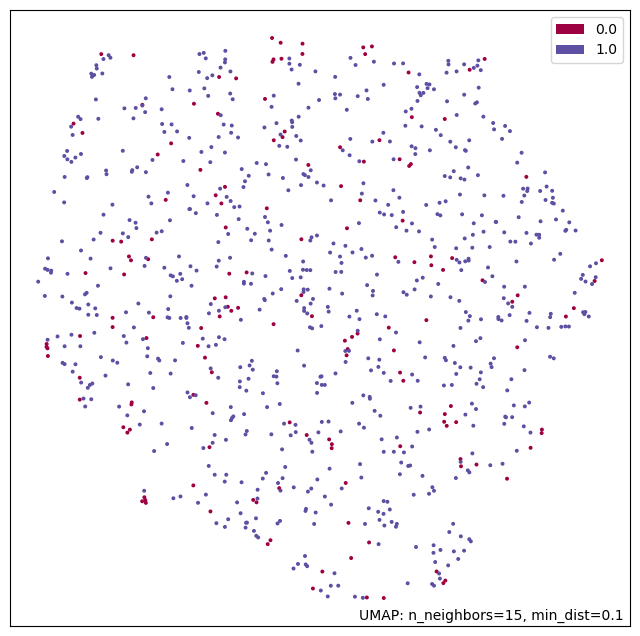

In [197]:
umap.plot.points(mapper, labels=Label)

## 3.1 KNN to transfer labels

In [198]:
from sklearn.neighbors import KNeighborsClassifier
Braak = anndata_ROSMAP.obs['braaksc']
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(alpha_best,Braak)

KNeighborsClassifier(n_neighbors=1)

In [199]:
y_pred = np.zeros(len(ANMergeSampleID))
y_pred = -1+y_pred

for i in range(len(ANMergeSampleID)):
    y_pred[i] = neigh.predict([beta_best[i,:]])

In [200]:
anndata_Target.obs['braaksc_trans'] = y_pred

In [201]:
anndata_Target.obs.head(2)

,DX,CDRSB_Month,braaksc_trans
116_S_1249,CN,0.0,4.0
037_S_4410,CN,0.0,5.0


# Classify

In [202]:
Label = list()
SID = list(anndata_Target.obs.index)

for gt in SID:
    CRD = anndata_Target.obs.loc[gt,:].CDRSB_Month
    Braak = anndata_Target.obs.loc[gt,:].braaksc_trans
    Dx = anndata_Target.obs.loc[gt,:].DX
    if CRD > 4 and Braak >=4:
        Label.append("Typical AD")
    elif CRD <= 4 and Braak >=4 and CRD > 0:
        Label.append("Asym AD")
    elif CRD > 4 and Braak <=2:
        Label.append("Low-NFT AD")
    elif CRD <= 0.5 and Braak <=2:
        Label.append("Control")
    else:
        Label.append("Others")

In [203]:
anndata_Target.obs['NewLabel'] = Label

In [204]:
df = anndata_Target.obs[anndata_Target.obs.NewLabel=='Asym AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_Asym = (counter['CN'] + counter['MCI']) / df.shape[0]
print("Asym AD transfer accuracy is ", Acc_Asym)

Counter({'MCI': 333, 'Dementia': 31, 'CN': 19})
Asym AD transfer accuracy is  0.9190600522193212


In [205]:
df = anndata_Target.obs[anndata_Target.obs.NewLabel=='Typical AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_TAD = (counter['Dementia'] + counter['MCI']) / df.shape[0]
print("Typical AD transfer accuracy is ", Acc_TAD)

Counter({'Dementia': 80, 'MCI': 27, 'CN': 15})
Typical AD transfer accuracy is  0.8770491803278688


In [206]:
df = anndata_Target.obs[anndata_Target.obs.NewLabel=='Low-NFT AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_LTau = (counter['Dementia'] + counter['MCI']) / df.shape[0]
print("Low-NFT AD transfer accuracy is ", Acc_LTau)

Counter({'Dementia': 4, 'CN': 2, 'MCI': 1})
Low-NFT AD transfer accuracy is  0.7142857142857143


In [207]:
df = anndata_Target.obs[anndata_Target.obs.NewLabel=='Control']
counter = collections.Counter(df['DX'])
print(counter)
Acc_CN = (counter['CN']) / df.shape[0]
print("Control transfer accuracy is ", Acc_CN)

Counter({'CN': 16, 'MCI': 6})
Control transfer accuracy is  0.7272727272727273


In [208]:
df = anndata_Target.obs[anndata_Target.obs.NewLabel=='Others']
counter = collections.Counter(df['DX'])
print(counter)

Counter({'CN': 194, 'MCI': 15, 'Dementia': 1})


In [209]:
Acc_Avg = (Acc_Asym + Acc_CN + Acc_LTau + Acc_TAD)/4
print("Avg acc is ", Acc_Avg)

Avg acc is  0.809416918526408


In [210]:
counter = collections.Counter(Label)
print(counter)

Counter({'Asym AD': 383, 'Others': 210, 'Typical AD': 122, 'Control': 22, 'Low-NFT AD': 7})


In [211]:
len(Label)-247

497

## 3.2 Evaulation

In [20]:
#Mapping = {'Control': 0, 'Typical.AD': 1, 'Asym.AD': 2, 'LowNFT.AD': 3}
#Mapping = {'CTL': 0, 'AD': 1, 'MCI': 2}


pred_ind_cn = np.where(y_pred==0)[0]
true_ind_cn = np.where(y_true==0)[0]
overlap = list(set(pred_ind_cn) & set(true_ind_cn))

pred_ind_aad = np.where(y_pred==2)[0]
true_ind_aad = np.where(y_true==2)[0]
overlap = list(set(pred_ind_aad) & set(true_ind_aad))

pred_ind_tad = np.where(y_pred==1)[0]
true_ind_tad = np.where(y_true==1)[0]
true_ind_tad_aad = list(true_ind_aad) + list(true_ind_tad)
overlap = list(set(pred_ind_tad) & set(true_ind_tad_aad))
print("precision of TAD is ", len(overlap)/len(pred_ind_tad))

pred_ind_aad_cn = list(pred_ind_aad) #+ list(pred_ind_cn)
true_ind_aad_cn = list(true_ind_cn) + list(true_ind_aad)
overlap = list(set(pred_ind_aad_cn) & set(true_ind_aad_cn))
print("precision of AAD  is ", len(overlap)/len(pred_ind_aad_cn))

pred_ind_aad_cn = list(pred_ind_cn) #list(pred_ind_aad) + 
true_ind_aad_cn = list(true_ind_cn) + list(true_ind_aad)
overlap = list(set(pred_ind_aad_cn) & set(true_ind_aad_cn))
if len(pred_ind_aad_cn) == 0:
    print("precision of CN  is 0")
else:
    print("precision of CN  is ", len(overlap)/len(pred_ind_aad_cn))

pred_ind_lt = np.where(y_pred==3)[0]
true_ind_lt = np.where(y_true==1)[0]
true_ind_lt_aad = list(true_ind_aad) + list(true_ind_lt)
overlap = list(set(pred_ind_lt) & set(true_ind_lt_aad))
if len(pred_ind_lt) == 0:
    print("precision of LowTau is 0")
else:
    print("precision of LowTau is ", len(overlap)/len(pred_ind_lt))


precision of TAD is  0.6859903381642513
precision of AAD  is  0.854679802955665
precision of CN  is  0.8584905660377359
precision of LowTau is  0.68
